# Data Science Lab Project 2022 Winter Session (Word2Vec part)

In order to run this code you need to install:
- emot
- nltk
- html
- gensim
- adjustText
- tqdm
- tensorflow

## 1) Data exploration

In [2]:
import pandas as pd

df = pd.read_csv("development.csv",parse_dates=['date'])

display(df)

/Users/giovannimantegna/opt/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


,sentiment,ids,date,flag,user,text
0,1,1833972543,2009-05-18 01:08:27,NO_QUERY,Killandra,"@MissBianca76 Yes, talking helps a lot.. going..."
1,1,1980318193,2009-05-31 06:23:17,NO_QUERY,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...
2,1,1994409198,2009-06-01 11:52:54,NO_QUERY,yaseminx3,@PleaseBeMine Something for your iphone
3,0,1824749377,2009-05-17 02:45:34,NO_QUERY,no_surprises,@GabrielSaporta couldn't get in to the after p...
4,0,2001199113,2009-06-02 00:08:07,NO_QUERY,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...
...,...,...,...,...,...,...
224989,0,2261324310,2009-06-20 20:36:48,NO_QUERY,CynthiaBuroughs,@Dropsofreign yeah I hope Iran people reach fr...
224990,1,1989408152,2009-06-01 01:25:45,NO_QUERY,unitechy,Trying the qwerty keypad
224991,0,1991221316,2009-06-01 06:38:10,NO_QUERY,Xaan,I love Jasper &amp; Jackson but that wig in th...
224992,0,2239702807,2009-06-19 08:51:56,NO_QUERY,Ginger_Billie,I am really tired and bored and bleh! I feel c...


Missing Values

In [3]:
df.isnull().sum()

sentiment    0
ids          0
date         0
flag         0
user         0
text         0
dtype: int64

Cardinality

In [4]:
df.nunique()

sentiment         2
ids          224716
date         189779
flag              1
user          10647
text         223106
dtype: int64

Unbalanced Classes

In [5]:
df['sentiment'].value_counts()

1    130157
0     94837
Name: sentiment, dtype: int64

Temporal range

In [6]:
print(max(df["date"]))
print(min(df["date"]))

2009-06-25 10:28:28
2009-04-06 22:19:57


# Duplicate Drop

In [7]:
print(df['text'].nunique(), df['ids'].nunique())

223106 224716


In [8]:
ids = df["ids"]
data_clean = df.drop(df[ids.isin(ids[ids.duplicated()])].index)
data_clean = data_clean.drop_duplicates(subset=['text'])

data_clean.nunique()

sentiment         2
ids          222833
date         188491
flag              1
user          10646
text         222833
dtype: int64

# 2) Preprocessing step

Methods

In [13]:
import re
import string as st
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
import emot
import nltk
import numpy as np
emot_obj = emot.core.emot() 
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def load_dict_smileys():
    return {
  ":-)": "smiley",
  ":)": "smiley",
  ":d": "smiley",
  "xd": "smiley",
  ":')": "smiley",
  ":'d": "smiley",
  ":3": "smiley",
  ":]": "smiley",
  ":^)": "smiley",
  ":-]": "smiley",
  ":-3": "smiley",
  ":->": "smiley",
  ":))": "smiley",
  "8-)": "cool",
  "8)": "cool",
  "8-d": "cool",
  "b)": "cool",
  "bd": "cool",
  ":-}": "smiley",
  ":>": "smiley",
  ":}": "smiley",
  ":o)": "smiley",
  ":c)": "smiley",
  "=)": "smiley",
  "=d": "smiley",
  "=]": "smiley",
  ":-d": "smiley",
  ":o": "surprised",
  "=o": "surprised",
  ":0": "surprised",
  ":(": "sad",
  ":c": "sad",
  "=(": "sad",
  "=c": "sad",
  ":-(": "sad",
  ":-c": "sad",
  ":-<": "sad",
  ":<": "sad",
  ":[": "sad",
  ":{": "sad",
  ":'(": "crying",
  ":P": "playful",
  "xp": "playful",
  "=P": "playful",
  "xb": "playful",
  "❤": "love",
  "</3": "sad",
  ":/": "worried",
  ":-/": "worried"
  }

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/giovannimantegna/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/giovannimantegna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
import re
from functools import partial
from collections import Counter
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

def removeUnicode(text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

def replaceURL(text):
    """ Replaces url address with "url" """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
    text = re.sub(r'#([^\s]+)', '', text)
    return text

def replaceAtUser(text):
    """ Replaces "@user" with "atUser" """
    text = re.sub('@[^\s]+','',text)
    return text

def removeHashtagInFrontOfWord(text):
    """ Removes hastag in front of a word """
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def removeNumbers(text):
    """ Removes integers """
    text = ''.join([i for i in text if not i.isdigit()])         
    return text

def replaceMultiExclamationMark(text):
    """ Replaces repetitions of exlamation marks """
    text = re.sub(r"(\!)\1+", ' multiExclamation ', text)
    return text

def replaceMultiQuestionMark(text):
    """ Replaces repetitions of question marks """
    text = re.sub(r"(\?)\1+", ' multiQuestion ', text)
    return text

def replaceMultiStopMark(text):
    """ Replaces repetitions of stop marks """
    text = re.sub(r"(\.)\1+", ' multiStop ', text)
    return text

def countMultiExclamationMarks(text):
    """ Replaces repetitions of exlamation marks """
    return len(re.findall(r"(\!)\1+", text))

def countMultiQuestionMarks(text):
    """ Count repetitions of question marks """
    return len(re.findall(r"(\?)\1+", text))

def countMultiStopMarks(text):
    """ Count repetitions of stop marks """
    return len(re.findall(r"(\.)\1+", text))

def countElongated(text):
    """ Input: a text, Output: how many words are elongated """
    regex = re.compile(r"(.)\1{2}")
    return len([word for word in text.split() if regex.search(word)])

def countAllCaps(text):
    """ Input: a text, Output: how many words are all caps """
    return len(re.findall("[A-Z0-9]{3,}", text))

""" Creates a dictionary with slangs and their equivalents and replaces them """
with open('slang.txt') as file:
    slang_map = dict(map(str.strip, line.partition('\t')[::2])
    for line in file if line.strip())

slang_words = sorted(slang_map, key=len, reverse=True) # longest first for regex
regex = re.compile(r"\b({})\b".format("|".join(map(re.escape, slang_words))))
replaceSlang = partial(regex.sub, lambda m: slang_map[m.group(1)].replace(" ", "_"))

def countSlang(text):
    """ Input: a text, Output: how many slang words and a list of found slangs """
    slangCounter = 0
    slangsFound = []
    tokens = nltk.word_tokenize(text)
    for word in tokens:
        if word in slang_words:
            slangsFound.append(word)
            slangCounter += 1
    return slangCounter, slangsFound

""" Replaces contractions from a string to their equivalents """
contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
def replaceContraction(text):
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

def replaceElongated(word):
    """ Replaces an elongated word with its basic form, unless the word exists in the lexicon """

    repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
    repl = r'\1\2\3'
    if wordnet.synsets(word):
        return word
    repl_word = repeat_regexp.sub(repl, word)
    if repl_word != word:      
        return replaceElongated(repl_word)
    else:       
        return repl_word

def removeEmoticons(text):
    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text

def countEmoticons(text):
    """ Input: a text, Output: how many emoticons """
    return len(re.findall(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', text))


### Spell Correction begin ###
""" Spell Correction http://norvig.com/spell-correct.html """
def words(text): return re.findall(r'\w+', text.lower())


def spellCorrection(word): 
    """ Most probable spelling correction for word. """
    return max(candidates(word), key=P)

def candidates(word): 
    """ Generate possible spelling corrections for word. """
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    """ The subset of `words` that appear in the dictionary of WORDS. """
    return set(w for w in words if w in WORDS)

def edits1(word):
    """ All edits that are one edit away from `word`. """
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    """ All edits that are two edits away from `word`. """
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

### Spell Correction End ###

### Replace Negations Begin ###

def replace(word, pos=None):
    """ Creates a set of all antonyms for the word and if there is only one antonym, it returns it """
    antonyms = set()
    for syn in wordnet.synsets(word, pos=pos):
      for lemma in syn.lemmas():
        for antonym in lemma.antonyms():
          antonyms.add(antonym.name())
    if len(antonyms) == 1:
      return antonyms.pop()
    else:
      return None

def replaceNegations(text):
    """ Finds "not" and antonym for the next word and if found, replaces not and the next word with the antonym """
    list_text = text.split()
    i, l = 0, len(list_text)
    words = []
    while i < l:
      word = list_text[i]
      if word == 'not' and i+1 < l:
        ant = replace(list_text[i+1])
        if ant:
          text = text.replace(list_text[i+1], ant)
          words.append(ant)
          i += 2
          continue
      #words.append(word)
      i += 1
    if words:
      text = text.replace("not", "")
    return text

### Replace Negations End ###

def addNotTag(text):
    """ Finds "not,never,no" and adds the tag NEG_ to all words that follow until the next punctuation """
    transformed = re.sub(r'\b(?:not|never|no)\b[\w\s][\w]+', 
        lambda match: re.sub(r'(\s+)(\w+)', r'\1NEG_\2', match.group(0)), 
        text,
        flags=re.IGNORECASE)
    return transformed



def addCapTag(word):
    """ Finds a word with at least 3 characters capitalized and adds the tag ALL_CAPS_ """
    if(len(re.findall("[A-Z]{3,}", word))):
        word = word.replace('\\', '' )
        transformed = re.sub("[A-Z]{3,}", "ALL_CAPS_"+word, word)
        return transformed
    else:
        return word

def replaceElongatedWord(text, stoplist):

  tokens = text.split() # Technique 13: part of speech tagging  
  for w in tokens:
      if ( w not in stoplist):
          #final_word = addCapTag(w[0])
          #final_word = final_word.lower()
          final_word = replaceElongated(w)
          if len(final_word)>1:
              #final_word = spellCorrection(final_word)
              text = text.replace(w, final_word)
  return text

In [17]:
def remove_emoticons(tweet):
    smilies = load_dict_smileys()
    split_tweet = tweet.split()
    for key,val in smilies.items():
        if key in split_tweet or key[::-1] in split_tweet:
                new_tweet = tweet.replace(key, val)
                tweet = new_tweet
    return tweet

In [18]:
def detect_emoticons_library_rep(text):
  text = re.sub("(http|ftp|https)://[\w-]+(\.[\w-]+)+([\w.,@?^=%&amp;:/~+#-]*[\w@?^=%&amp;/~+#-])?","", text)
  text = re.sub(r'(\W)(?=\1)', '', text) #remove multiple punctuations
  text = re.sub('[a-z0-9]+:', '', text)
  emot = emot_obj.emoticons(str(text).lower().strip())
  if emot['flag']:
    for count, face in enumerate(emot['value']):
      text = text.lower().replace(face, emot['mean'][count].split()[0].lower())
  return text

In [19]:
def detect_emoticons_library(text):
  text = re.sub("(http|ftp|https)://[\w-]+(\.[\w-]+)+([\w.,@?^=%&amp;:/~+#-]*[\w@?^=%&amp;/~+#-])?","", text)
  text = re.sub(r'(\W)(?=\1)', '', text) #remove multiple punctuations
  text = re.sub('[a-z0-9]+:', '', text)
  emot = emot_obj.emoticons(str(text).lower().strip())
  if emot['flag']:
    return (emot['mean'], emot['value'])

In [20]:
def detect_emoticons_dict(tweet):
  tweet = re.sub("(http|ftp|https)://[\w-]+(\.[\w-]+)+([\w.,@?^=%&amp;:/~+#-]*[\w@?^=%&amp;/~+#-])?","", tweet)
  tweet = re.sub(r'(\W)(?=\1)', '', tweet)
  tweet = re.sub('[a-z0-9]+:', '', tweet)
  tweet = tweet.lower()
  smilies = load_dict_smileys()
  for key,val in smilies.items():
    if key in tweet or key[::-1] in tweet:
      new_tweet = tweet.replace(key, val)
      tweet = new_tweet
  return tweet

In [21]:
def remove_noise(tweet):
    tweet = re.sub("(@[A-Za-z0–9_]+)","", tweet)
    tweet = re.sub("(http|ftp|https)://[\w-]+(\.[\w-]+)+([\w.,@?^=%&amp;:/~+#-]*[\w@?^=%&amp;/~+#-])?","", tweet)
    tweet = remove_emoticons(tweet)
    tweet = re.sub("(a*ha+h[ha]*|o?l+o+l+[ol]*)","ahah",tweet)
    tweet = "".join([char if char not in st.punctuation else " " for char in tweet])
    tweet = re.sub("\\s+", " ", tweet) 
    tweet = re.sub("[0–9]+", "", tweet)
    tweet = re.sub("[^A-Za-z0–9_. ]+","",tweet)
 
    return tweet

In [22]:
def pre_proc(text, stoplist):
  text = text.lower()
  text = replaceMultiExclamationMark(text)
  text = replaceMultiQuestionMark(text)
  text = replaceMultiStopMark(text)
  text = text.replace("&amp", "")
  text = re.sub("(a*ha+h[ha]*)","ahah ",text) #|o?l+o+l+[ol]* for lol
  text = removeUnicode(text) 
  text = replaceURL(text)
  text = detect_emoticons_library_rep(text)
  text = detect_emoticons_dict(text)
  text = replaceAtUser(text)
  text = removeHashtagInFrontOfWord(text)
  text = replaceElongatedWord(text, stoplist)
  text = replaceSlang(text)
  text = unescape(text)
  text = replaceContraction(text)
  text = replaceNegations(text)
  text = removeNumbers(text)
  text = "".join([char if char not in st.punctuation.replace("_","") else " " for char in text])
  text = addNotTag(text)
  return text

In [23]:
stoplist = stopwords.words('english')

In [24]:
from html import unescape

In [25]:
data_clean['text'] = data_clean['text'].str.lower()

In [26]:
data_clean["text"] = data_clean["text"].apply(lambda x:  pre_proc(x, stoplist))

# 3) WordCloud visualization

(-0.5, 1999.5, 999.5, -0.5)

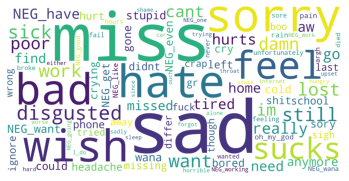

In [27]:
from collections import Counter
from itertools import repeat

positive_dataframe = data_clean.loc[data_clean['sentiment'] == 1]
negative_dataframe = data_clean.loc[data_clean['sentiment'] == 0]

import nltk
from nltk.tokenize import word_tokenize,sent_tokenize

tokenized_positive_words = []

for item in positive_dataframe['text']:
    tokenized_positive_words += word_tokenize(item)
    

tokenized_negative_words = []

for item in negative_dataframe['text']:
    tokenized_negative_words += word_tokenize(item)
    
c1 = [x for x in tokenized_positive_words if x not in stoplist]
counts1 = Counter(c1)


c0 = [x for x in tokenized_negative_words if x not in stoplist]
counts0 = Counter(c0)

positive = Counter(counts1)
positive.subtract(counts0)

negative = Counter(counts0)
negative.subtract(counts1)

most_positive = positive.most_common(100)    
most_negative = negative.most_common(100)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

dict_negative = dict(most_negative) 
wc = WordCloud(background_color="white",width=2000,height=1000, max_words=100,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(dict_negative)
plt.imshow(wc)
plt.axis("off")
#plt.savefig('Bad_sentiment.png', dpi=800)


(-0.5, 1999.5, 999.5, -0.5)

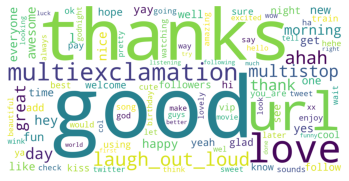

In [28]:
dict_positive = dict(most_positive) 
wc = WordCloud(background_color="white",width=2000,height=1000, max_words=100,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(dict_positive)
plt.imshow(wc)
plt.axis("off")
#plt.savefig('Good_sentiment.png', dpi=800)

# 4) Exploratory task of Word2vec Model

Tokenizzazione delle parole

In [29]:
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize

tokenized_sentences = []

for item in data_clean['text']:
    sent_tokenize(item)
    tokenized_sentences += [word_tokenize(t) for t in sent_tokenize(item)]

Creazione del modello Word2Vec

In [30]:
import gensim.models

from gensim.models import Phrases
from gensim.models.phrases import Phraser

model = gensim.models.Word2Vec(tokenized_sentences,vector_size=300, min_count=30)

In [31]:
from sklearn.manifold import TSNE

list_of_peculiar_words = ["sad", "happy" , "funny","obama","president","edward","upset","food","drink","meal","mtv","proud","crying","cute","sexy","talented","present","mother","father","brother", "movie", "awards","hate","eat","meal","dog","cat","friend","stupid","italy","europe","france","germany","usa","music","beyonce","eminem","rock","rain","water","jazz","church","cinema","gym","yoga","sex","drugs"]

list_of_index = []

for item in list_of_peculiar_words:
    list_of_index.append(model.wv.key_to_index[item])

In [32]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

In [33]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in list(model.wv.key_to_index.keys()):
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    texts = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        if(i in list_of_index):
            plt.scatter(x[i],y[i],s=120,c='black')
        if(i in list_of_index):
            texts.append(plt.text(s=labels[i],
                x=x[i],
                y=y[i],
                size = 20,
                weight='bold',
                ha='right',
                va='bottom')
                        )
    adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.1))
    plt.axis("off")
    plt.savefig('Word2VecTSNE.png', dpi=800)
    plt.show()

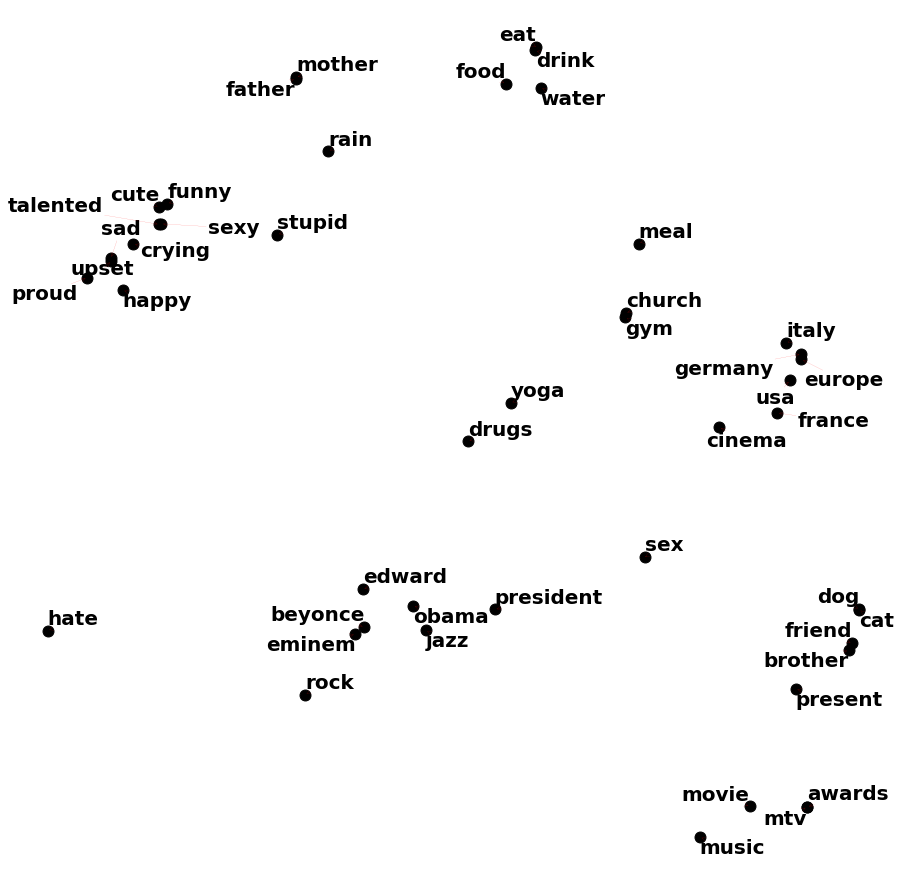

In [34]:
tsne_plot(model)

### Using word2vec model for most_similar words

In [35]:
print(model.wv.most_similar(positive=['stupid'], topn=10))

[('dumb', 0.6304368376731873), ('gay', 0.6058964133262634), ('dead', 0.5985332727432251), ('lame', 0.597578763961792), ('gr', 0.5875093936920166), ('slow', 0.5442911982536316), ('wack', 0.540636420249939), ('shitty', 0.5239447355270386), ('itchy', 0.5151061415672302), ('argh', 0.5105482339859009)]


In [36]:
print(model.wv.most_similar(positive=['sad'], topn=10))

[('upset', 0.6803024411201477), ('angry', 0.626072883605957), ('annoyed', 0.6062860488891602), ('depressed', 0.5855772495269775), ('bummed', 0.5786518454551697), ('lame', 0.5556622743606567), ('anoying', 0.5511687994003296), ('guted', 0.5483900308609009), ('crying', 0.5441049337387085), ('disappointed', 0.5435932278633118)]


In [37]:
print(model.wv.most_similar(positive=['cute'], topn=10))

[('adorable', 0.851276695728302), ('prety', 0.7547346949577332), ('funy', 0.744523823261261), ('sexy', 0.7239966988563538), ('funny', 0.7238870859146118), ('swet', 0.708251953125), ('talented', 0.6793572902679443), ('cool', 0.6767098307609558), ('young', 0.6716366410255432), ('hilarious', 0.6494309306144714)]


# 5) Classification task ( hold-out 80-20 )

In [38]:
from sklearn.model_selection import train_test_split 

X = pd.DataFrame(data_clean,columns=["text"])
y = data_clean["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,random_state = 42)

Tokenize sentenzes

In [39]:
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize

tokenized_sentences_train = []

for item in X_train["text"]:
    sent_tokenize(item)
    if [word_tokenize(t) for t in sent_tokenize(item)] not in stoplist:
        tokenized_sentences_train += [word_tokenize(t) for t in sent_tokenize(item)]

In [40]:
dim_vector = 400

model_train = gensim.models.Word2Vec(tokenized_sentences_train,vector_size= dim_vector, min_count=30)

Extract Mean word2vec vector from a tweet

In [41]:
def extract_feature(text):
    
    
    vectors= list()
    tokenize_words = word_tokenize(text)
    flag=True
    
    for k in tokenize_words:
        try:
            
            vectors.append(model_train.wv[k])
            flag = False
        except KeyError as e:
            continue 

    if flag:
        vectors.append(np.zeros((dim_vector,)))
            
    mean_vector = np.mean( vectors , axis=0) 
    
    return mean_vector

In [42]:
from tqdm import tqdm

tqdm.pandas()
X_train['feature'] = X_train['text'].progress_map(lambda x: extract_feature(x))

100%|██████████| 178266/178266 [02:18<00:00, 1288.79it/s]
<ipython-input-42-d65f091ad7aa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['feature'] = X_train['text'].progress_map(lambda x: extract_feature(x))


In [43]:
X_train_feature = X_train['feature'].to_numpy()
X_train_feature_concat = np.concatenate( X_train_feature, axis=0 )
X_train_feature_final = X_train_feature_concat.reshape(X_train_feature.size,dim_vector)

In [44]:
X_test['feature'] = X_test['text'].apply(lambda x: extract_feature(x))

<ipython-input-44-dc7a2547d319>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['feature'] = X_test['text'].apply(lambda x: extract_feature(x))


In [45]:
X_test_feature = X_test['feature'].to_numpy()
X_test_feature_concat = np.concatenate( X_test_feature, axis=0 )
X_test_feature_final = X_test_feature_concat.reshape(X_test_feature.size,dim_vector)

### Random Forest classifier

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf1 = RandomForestClassifier(n_estimators = 170,random_state=42,max_features="log2",n_jobs = -1)
clf1.fit(X_train_feature_final, y_train)
test_predictions_word2vec1 = clf1.predict(X_test_feature_final)
print(classification_report(y_test,test_predictions_word2vec1))

              precision    recall  f1-score   support

           0       0.72      0.63      0.67     18758
           1       0.75      0.82      0.79     25809

    accuracy                           0.74     44567
   macro avg       0.74      0.73      0.73     44567
weighted avg       0.74      0.74      0.74     44567



### LinearSVM model (it takes long time)

In [47]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=0, tol=1e-5, class_weight="balanced", verbose=1)
clf.fit(X_train_feature_final,y_train)
test_predictions_svm_word2vec = clf.predict(X_test_feature_final)
print(classification_report(y_test,test_predictions_svm_word2vec))

[LibLinear]

/Users/giovannimantegna/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


              precision    recall  f1-score   support

           0       0.69      0.77      0.73     18758
           1       0.82      0.75      0.78     25809

    accuracy                           0.76     44567
   macro avg       0.75      0.76      0.75     44567
weighted avg       0.76      0.76      0.76     44567



### Logistic Regression

In [48]:
from sklearn.linear_model import  LogisticRegression
from sklearn import feature_extraction, model_selection
from sklearn import metrics

lr = LogisticRegression(penalty='l2', max_iter=500, C=1)
lr.fit(X_train_feature_final,y_train)
test_predictions_svm_word2vec = lr.predict(X_test_feature_final)
print(classification_report(y_test,test_predictions_svm_word2vec))


              precision    recall  f1-score   support

           0       0.73      0.66      0.70     18758
           1       0.77      0.82      0.80     25809

    accuracy                           0.76     44567
   macro avg       0.75      0.74      0.75     44567
weighted avg       0.75      0.76      0.75     44567



/Users/giovannimantegna/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Grid for Logistic Regression

In [49]:
from sklearn.model_selection import GridSearchCV


param_grid = { 'penalty': ['l1', 'l2'],
               'C': [1.0, 10.0, 100.0]}
              

gs_lr = GridSearchCV(LogisticRegression(random_state=0), param_grid,
                           scoring='f1',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)
gs_lr.fit(X_train_feature_final,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/giovannimantegna/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.7951493         nan 0.79511509        nan 0.79513821]
  warnings.warn(
/Users/giovannimantegna/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0), n_jobs=-1,
             param_grid={'C': [1.0, 10.0, 100.0], 'penalty': ['l1', 'l2']},
             scoring='f1', verbose=1)

In [50]:
print('Best parameter set: ' + str(gs_lr.best_params_))
print('Best f1: %.3f' % gs_lr.best_score_)

Best parameter set: {'C': 1.0, 'penalty': 'l2'}
Best f1: 0.795


In [51]:
clf = gs_lr.best_estimator_
print('f1 in test: %.3f' % clf.score(X_test_feature_final, y_test))

f1 in test: 0.755


# 6) Exploratory task with date and user

## Exploratory task with Date

Sort data_clean by date

In [52]:
data_clean_sortbydate = data_clean.sort_values(by="date")
display(data_clean_sortbydate)

,sentiment,ids,date,flag,user,text
126514,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,no it is misbehave at al i am mad why am ...
23977,0,1467811594,2009-04-06 22:20:03,NO_QUERY,coZZ,hey long time no NEG_se yes multistop rains ...
198394,0,1467813579,2009-04-06 22:20:31,NO_QUERY,starkissed,ah ive always wanted to see rent love the sou...
188913,0,1467813782,2009-04-06 22:20:34,NO_QUERY,gi_gi_bee,oh dear were you drinking out of the forgott...
212404,0,1467819650,2009-04-06 22:22:05,NO_QUERY,antzpantz,yay i am happy for you with your job but th...
...,...,...,...,...,...,...
94121,0,2329167439,2009-06-25 10:25:48,NO_QUERY,Tracey_Mac,already dreading being car les tomorrow multie...
71783,0,2329176482,2009-06-25 10:26:26,NO_QUERY,kinaton,wishes he could win a holiday for his familty
40052,0,2329197868,2009-06-25 10:27:58,NO_QUERY,Arantza92,yes he was such a jerk and so mean i really ...
90305,0,2329199154,2009-06-25 10:28:03,NO_QUERY,shen_nanigans,no i slept ina little multistop but it still...


Create cumulative sentiment time series

In [53]:
Sum = []
sum_ = 0

for i in range(0,len(data_clean_sortbydate)):
    sum_ += data_clean_sortbydate["sentiment"].iloc[i]
    Sum.append(sum_)

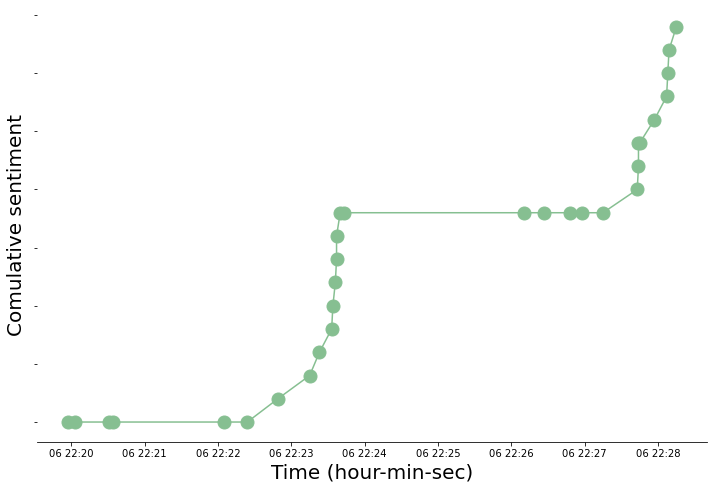

In [54]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter

fig, ax = plt.subplots(figsize=(12,8))
ax.set_ylabel('Comulative sentiment',size=20)
ax.set_xlabel('Time (hour-min-sec)',size=20)
ax.yaxis.set_major_formatter(FixedFormatter(list()))
#plt.title("Cumulative sentiment time series",size=20)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Draw horizontal axis lines
vals = ax.get_yticks()

# Remove title
ax.set_title("")

plt.plot_date(data_clean_sortbydate["date"][0:30],Sum[0:30],markersize=13,marker="o", linestyle='-',color='#86bf91', zorder=2)
#plt.savefig('SentimentTimeSerie.png', dpi=500)

## Exploratory task with User (it takes long time)

In [55]:
list_users = list(data_clean["user"].unique())

positive_count = []
negative_count = []
tot_count = []
stat = []


for i in range(0,len(list_users)):
    
    current_dataset = data_clean.loc[data_clean['user'] == list_users[i]]
    total = current_dataset["sentiment"].count()
    tot_count.append(total)
    positive = current_dataset.loc[current_dataset['sentiment'] == 1]["sentiment"].count()
    positive_count.append(positive)
    negative = current_dataset.loc[current_dataset['sentiment'] == 0]["sentiment"].count()
    negative_count.append(negative)
    stat.append((positive - negative)/total)
    

In [56]:
df = pd.DataFrame(zip(list_users,positive_count,negative_count,tot_count,stat),columns =['User', 'positive',"negative","total","stat"])

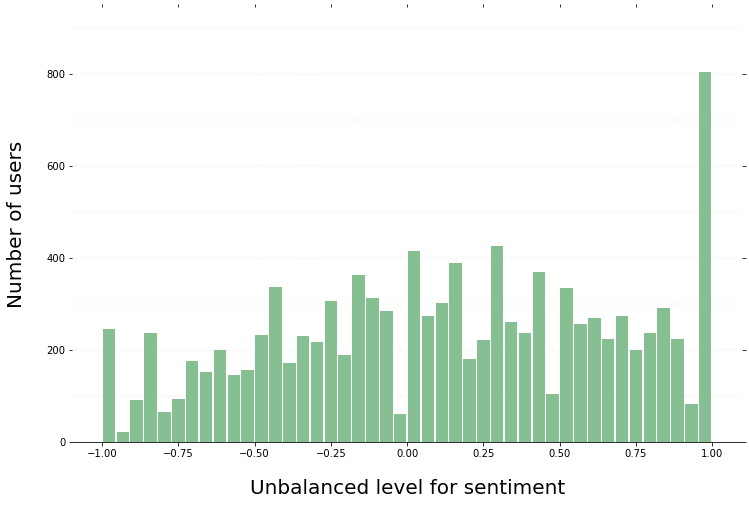

In [57]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter,StrMethodFormatter

ax = df.hist(column="stat",bins=44,grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Unbalanced level for sentiment", labelpad=20, size=20)

    # Set y-axis label
    x.set_ylabel("Number of users", labelpad=20, size=20)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

fig = x.get_figure()
#fig.savefig('UserHistogram.png', dpi=500)

The TF-IDF part and our best model are in the other file